## Speed dating data-set
#### Bart v. Helvert - November 2017

### 2.1 Unisex model

### <font color="green">Imports, preparation and configuration</font>

In [200]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import tree, preprocessing, metrics
import matplotlib.pyplot as plt
%matplotlib inline

import io
import graphviz as gv # not included in the standard anaconda installer (can be found in the Anaconda Navigator)
import pydotplus # not included in anaconda at all (use pip/conda install pydotplus in cmd/conda prompt etc)
from scipy import misc

In [201]:
from IPython.core.display import HTML # markdown cell styling and enabling/disabling warning messages
HTML("""
<style>
div.text_cell_render h1 {
font-size: 1.6em;
line-height:1.2em;
}

div.text_cell_render h2 { 
margin-bottom: -0.4em;
}

div.text_cell_render { 
font-size:1.2em;
line-height:1.2em;
font-weight:500;
}

div.text_cell_render p, li {
color:Navy;
}

</style>

<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.
""") 

In [202]:
# Loads the data
df= pd.read_csv("speed_dating_assignment.csv")

In [203]:
# Visualizes a decision tree and stores it
def visualize_tree(dec_tree, path, classnames, feat_names):
    dfile = io.StringIO()
    tree.export_graphviz(dec_tree, out_file = dfile, feature_names = feat_names)
    pydotplus.graph_from_dot_data(dfile.getvalue()).write_png(path)
    i = misc.imread(path)
    plt.imshow(i)

### <font color="green">Preparing the data</font>

In [204]:
df.head()

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


To make a valid comparison later in 2.2 the introduced features for the unisex model are the same as for the gender based model described in 1.3. We introduce the following new variables:

* <b>age_diff</b> <i>absolute difference between subject's age and partners age (age_o, see 1.1)</i> As concluded in 1.1, the number of decisions that a participant wanted to see a partner again was higher when there was a low age difference between the two. One can also imagine that the lower the age difference, people find it easier to communicate. Therefore, it could be that this is a important attribute on which the decision tree can split. 
* <b>attr_o</b> <i>rating by partner the night of the event, for all six attributes (attr,sinc,intel,fun,amb and shar)</i> Each participant rate their partner on six attributes on a scale of 1 -10 (1=awful, 10 = great). Therefore, the higher each partner scores, the better. So adding all these ratings to a total rating , which could be maximum a score of 60, could be a good indicidation whether the participant want to see their partner again. Note that these ratings are the same for all waves (except from the other ratings), so we don't need to convert them. 
* <b>race_equals</b> <i>boolean value, which is True if the race of the partner equals the race of the participant and False otherwise</i> One can imagine that people from the same race have similarities in their daily habits and culture in general. Therefore it could be interesting to see when participant and partner are from the same race, this increases the chance of seeing each other again. 
* <b>goal_equals</b> <i>boolean value, which is True if the goal of the partner equals the goal of the participant and False otherwise </i> When both people go on date with the same purpose, for example "looking for a serious relationship" or "to get a date", this could be increasing the fact that they wanted to see their partner again or not. When subjects have a different or the same primary goal, this could influence their decision. 

In [205]:
df_o = df.copy()
df_o = df_o.filter(items=['iid', 'age', 'race', 'goal'])
df_o.rename(columns={'iid': 'pid', 'age': 'age_o', 'race': 'race_partner', 'goal':'goal_partner'}, inplace = True)
df_o = df_o.drop_duplicates()

df_new = pd.merge(df, df_o, on=['pid'], how = 'left')
df = df_new.copy()

Just as in 1.2, only the missing values of age are filled in by the mean of the column. We don't do this for the other attributes, because this will affect the correctness of the model too much , as explained earlier in 1.2.

In [206]:
df = df[['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'gender', 'order','goal', 'field_cd', 'date','age', 'go_out', 'imprace', 'imprelig', 'dec', 'age_o', 'race', 'pid', 'iid', 'race_partner', 'goal_partner']]
df.age.fillna(df.age.median(), inplace = True)
print(df.shape)
df.info()

(8378, 22)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8378 entries, 0 to 8377
Data columns (total 22 columns):
attr            8176 non-null float64
sinc            8101 non-null float64
intel           8082 non-null float64
fun             8028 non-null float64
amb             7666 non-null float64
shar            7311 non-null float64
gender          8378 non-null int64
order           8378 non-null int64
goal            8299 non-null float64
field_cd        8296 non-null float64
date            8281 non-null float64
age             8378 non-null float64
go_out          8299 non-null float64
imprace         8299 non-null float64
imprelig        8299 non-null float64
dec             8378 non-null int64
age_o           8274 non-null float64
race            8315 non-null float64
pid             8368 non-null object
iid             8378 non-null int64
race_partner    8305 non-null float64
goal_partner    8289 non-null float64
dtypes: float64(17), int64(4), object(1)
memory usage: 

In [207]:
df = df.dropna().reset_index(drop=True)

### <font color="green">Calculating new features</font>

As described in 1.3 we calculate the new features mentioned above

In [208]:
df['attr_o'] = df['attr'] + df['sinc'] + df['intel'] + df['fun'] + df['amb'] + df['shar']
df = df.drop(['attr', 'sinc', 'intel', 'fun', 'shar', 'amb'], axis = 1)
df['age_diff'] = abs(df['age'] - df['age_o'])
df['race_equals'] = (df['race'] == df['race_partner'])
df['goal_equals'] = df.apply(lambda r: r.goal == r.goal_partner, axis = 1)
df = df[['gender', 'order','goal', 'field_cd', 'date','age', 'go_out', 'imprace', 'imprelig', 'dec','age_diff', 'attr_o', 'goal_equals']]
df.head()

,gender,order,goal,field_cd,date,age,go_out,imprace,imprelig,dec,age_diff,attr_o,goal_equals
0,0,4,2.0,1.0,7.0,21.0,1.0,2.0,4.0,1,6.0,40.0,False
1,0,3,2.0,1.0,7.0,21.0,1.0,2.0,4.0,1,1.0,41.0,False
2,0,10,2.0,1.0,7.0,21.0,1.0,2.0,4.0,1,1.0,42.0,True
3,0,5,2.0,1.0,7.0,21.0,1.0,2.0,4.0,1,2.0,42.0,True
4,0,7,2.0,1.0,7.0,21.0,1.0,2.0,4.0,1,3.0,37.0,False


### <font color="green">Training the model</font>

In [209]:
# Training the model
subjects_shuffle = df.sample(frac=1).reset_index(drop=True) # shuffle rows
x_data = subjects_shuffle.drop('dec', axis = 1) # dec is target attribute
labels = subjects_shuffle['dec']

Splitting the data into 80% training data and 20% test data

In [210]:
x_train, x_test, y_train, y_test = train_test_split(x_data, labels, test_size = 0.2)

Just like in 1.3 we train the model using a decision tree and use the same parameters

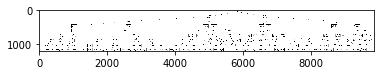

In [211]:
dec_tree = tree.DecisionTreeClassifier(criterion = "gini", max_depth = 8, min_samples_split = 50, min_samples_leaf = 12)
dec_tree.fit(x_train, y_train)
col_names = dec_tree.classes_
feature_names = df.columns[0:(df.shape[1] - 1)] # the features (attributes) used in the model
visualize_tree(dec_tree, "unisex_decision_tree.png", col_names, feature_names)

Now we predict the other 20% of the data using the decision tree

In [212]:
pred = dec_tree.predict(x_test) # predicting 'dec' for data which the model has not seen yet

### <font color="green">Results</font>

In [213]:
print("Accuracy score: ", metrics.accuracy_score(y_test, pred))

Accuracy score:  0.694444444444


The accuracy of a predictive model has its limitations. It really depends on the randomness of how the data is shuffled and many other factors. A performance matrix contains the Precision and Recall performance of the decision tree, which gives far more information.

In [214]:
print(metrics.classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.71      0.77      0.74       769
          1       0.67      0.60      0.63       599

avg / total       0.69      0.69      0.69      1368



percentage "dec = 0" in the unisex data set:  56.67 %
percentage "dec = 1" in the unisex data set:  43.33 %


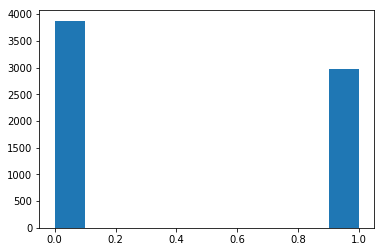

In [215]:
print('percentage "dec = 0" in the unisex data set: ', round((subjects_shuffle.loc[subjects_shuffle.dec == 0].shape[0] / subjects_shuffle.dec.values.shape[0]) * 100, 2), "%")
print('percentage "dec = 1" in the unisex data set: ', round((subjects_shuffle.loc[subjects_shuffle.dec == 1].shape[0] / subjects_shuffle.dec.values.shape[0]) * 100, 2), "%")
plt.hist(subjects_shuffle.dec)
plt.show()

The distribution of the binary values 0 and 1 in the <i>dec</i> column is not entirely fair for the subjects as can be seen in the histogram. In conclusive, the subjects expressed in approximately 43% of the dates their wish to see the particular date partner again, and in 57% of the dates they did not see a future with the respective date partner. This is to be expected because in 1.3 the male dec ratio was about 50/50 however female dec ratio was 63/37. The next step is to make some well-tought statements about the performance metrics depicted in the previous set of cells

<b>Model</b>
The support of this model is (769/(769 + 599))*100% = 56.2%, which is close to the distribution of the dec attribute in the complet data set (56.67%). For both dec = 0 and dec = 1 the <i>precision</i> and <i>recall</i> metrics are going to be evaluated.
* <b>for dec = 0</b> The classifier has a precision of 71% and a recall of 77%. This means that the classifier was able to classify 77% of the records with value 0 for 0, with the correct value of 0. So for 77% of the records the model predicts right for dec = 0. In other words, the classifier misses 23% of the records that should be 0 and classifies 29% of the records as 0 when they are in fact 1.
* <b>for dec = 1</b> The classifier has a precision of 67% and a recall of 60%. This means that the classifier was able to classify 61% of the records with value 0 for 0, with the correct value of 0. So for 60% of the records the model predicts right for dec = 1. In other words, the classifier misses 40% of the records that should be 1 and classifies 33% of the records as 1 when they are in fact 0.

The classifier is slightly better at predicting wheter a date is not wanted to when a date is wanted.